# Snapshotting with Devito

This notebook uses the water tank model from the previous notebook and introduce a snapshotting mechanism for creating visualisation for the problems.

# Setup the problem

The velocity profile of our model is the same as our first example. We have two domains: water in the middle domain with $1.5km/s$ and a border region of glass with $5.6km/s$. We add a single source in the middle of the top region and a set of receivers along the top of the water.

The quations and operators are also stays the same. To add a snapshotting term we create a subsampled time axis for and define a `TimeFunction` to copy the state of `u` to a buffer keeping the las `nsnaps` snapshots.  

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


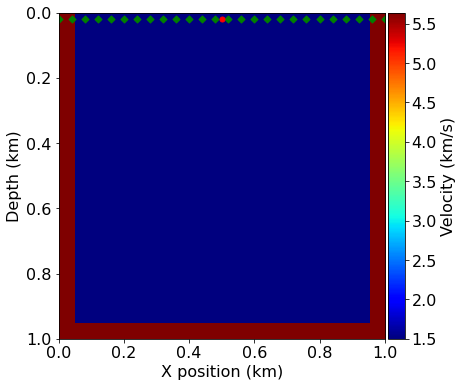

factor is 18
t_sub


Operator `Kernel` ran in 0.05 s


Saving snaps file
Dimensions: nz = 121, nx = 121


In [1]:

#NBVAL_IGNORE_OUTPUT
#%%flake8
%reset -f
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
from examples.seismic import Receiver
from examples.seismic import RickerSource
from examples.seismic import Model, plot_velocity, TimeAxis
from devito import TimeFunction
from devito import Eq, solve
from devito import Operator
from devito import ConditionalDimension


# Set velocity model
nx = 101
nz = 101
nb = 10
shape = (nx, nz)
spacing = (10., 10.)
origin = (0., 0.)
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = 1.5 # v in distilled water 1496.7 m/s
v[:, -5:] = 5.64 # v in glass 5640 m/s
v[:5, :] = 5.64 # v in glass 5640 m/s
v[-5:, :] = 5.64 # v in glass 5640 m/s
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0
tn = 2000.  # Simulation lasts tn milliseconds
dt = model.critical_dt  # Time step from model grid spacing
time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(
    name='src',
    grid=model.grid,
    f0=f0,
    time_range=time_range,
    npoint=1)  

src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 20.  # Depth is 20m

rec = Receiver(
    name='rec',
    grid=model.grid,
    npoint=101,
    time_range=time_range)  # new
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m
depth = rec.coordinates.data[:, 1]  # Depth is 20m


plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

#Used for reshaping
vnx = nx+20 
vnz = nz+20

# Using params for snapshotting
nsnaps = 103            # desired number of equally spaced snaps
factor = round(nt / nsnaps)  # subsequent calculated factor
print(f"factor is {factor}")

time_subsampled = ConditionalDimension(
    't_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=2,
                     save=nsnaps, time_dim=time_subsampled)
print(time_subsampled)

# Set symbolics for the wavefield object `u`, setting save on all time steps 
# (which can occupy a lot of memory), to later collect snapshots (naive method):

u = TimeFunction(name="u", grid=model.grid, time_order=2,
                 space_order=2, save=time_range.num)

# Set symbolics of the operator, source and receivers:
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u)
# The usual operator would be: op1 = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
op2 = Operator([stencil] + src_term + [Eq(usave, u)] + rec_term, subs=model.spacing_map)  # operator with snapshots
# Run the operator for `(nt-2)` time steps:
op2(time=nt - 2, dt=model.critical_dt)

print("Saving snaps file")
print("Dimensions: nz = {:d}, nx = {:d}".format(nz + 2 * nb, nx + 2 * nb))
filename = "snapshots/snaps.bin"
usave.data.tofile(filename)

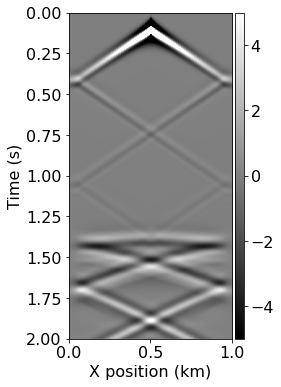

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, t0, tn)

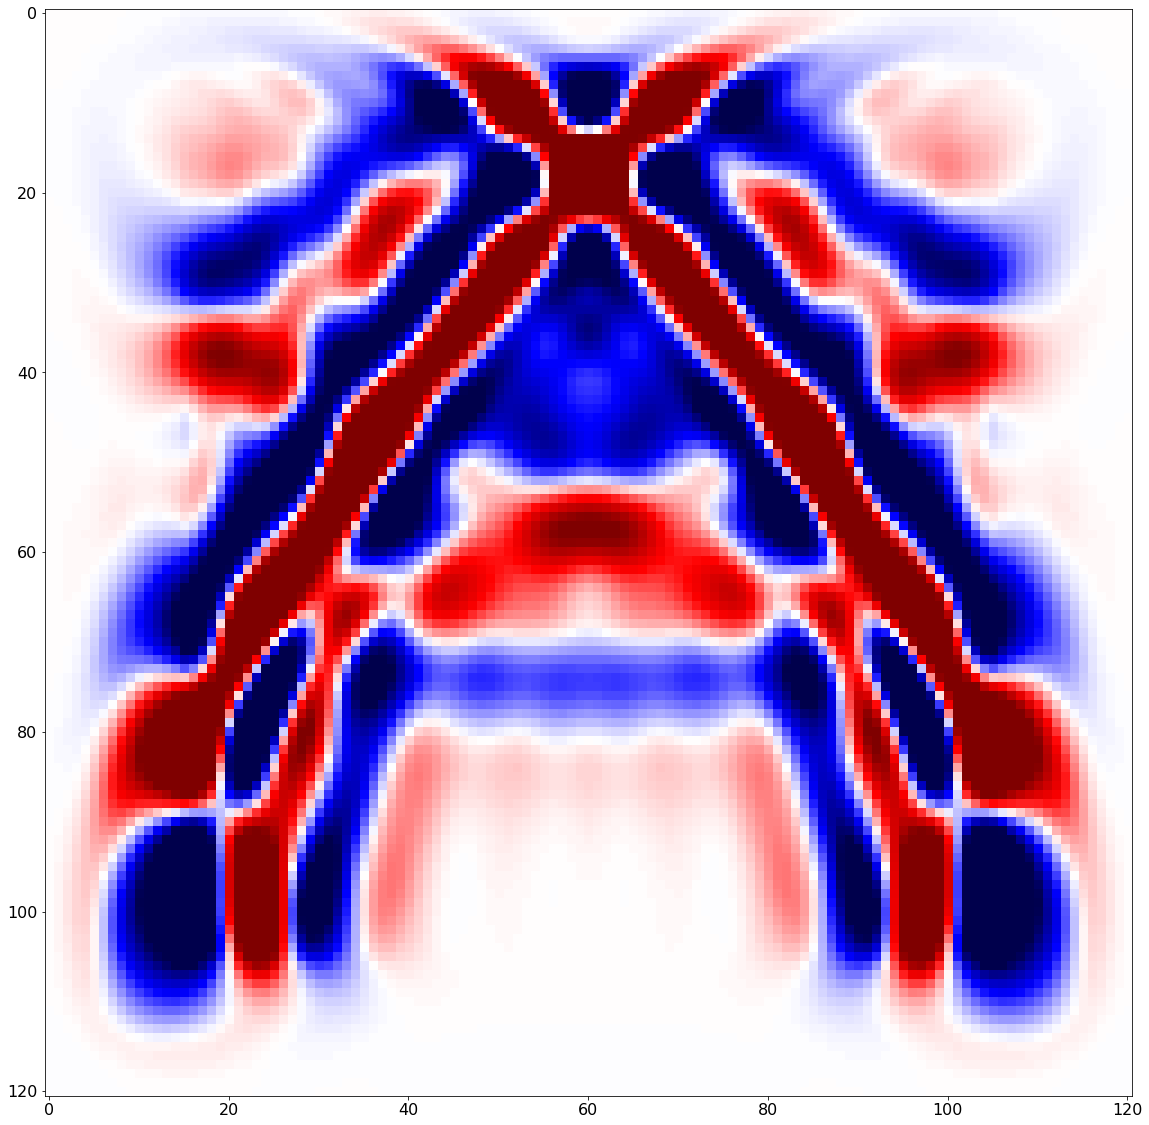

In [3]:
#NBVAL_IGNORE_OUTPUT
fobj = open("snapshots/snaps.bin", "rb")
snaps = np.fromfile(fobj, dtype=np.float32)
snaps = np.reshape(snaps, (nsnaps, vnx, vnz))
fobj.close()

plt.rcParams['figure.figsize'] = (20, 20)  # Increases figure size

imcnt = 1 # Image counter for plotting
plot_num = 20 # Number of images to plot
for i in range(0, plot_num):
   # plt.subplot(1, plot_num, i+1);
   imcnt = imcnt + 1
   ind = i * int(nsnaps/plot_num)
   plt.imshow(np.transpose(snaps[ind,:,:]), vmin=-1, vmax=1, cmap="seismic")
   filename = 'snapshots/tmp_%04d.png' % i
   plt.savefig(filename)

plt.show() 

In [4]:
#NBVAL_IGNORE_OUTPUT
#NBVAL_SKIP
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fobj = open("snapshots/snaps.bin", "rb")
snapsObj = np.fromfile(fobj, dtype=np.float32)
snapsObj = np.reshape(snapsObj, (nsnaps, vnx, vnz))
fobj.close()

fig, ax = plt.subplots()
matrice = ax.imshow(snapsObj[0, :, :].T, vmin=-1, vmax=1, cmap="seismic")
plt.colorbar(matrice)

plt.xlabel('x')
plt.ylabel('z')
plt.title('Modelling one shot over a 2-layer velocity model with Devito.')    

def update(i):
    matrice.set_array(snapsObj[i, :, :].T)
    return matrice,

# Animation
ani = animation.FuncAnimation(fig, update, frames=nsnaps, interval=50, blit=True)

plt.close(ani._fig)
HTML(ani.to_html5_video())